# KORONAVIRUS

U jeku nove epidemije naše su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u državi i svijetu, broju zaraženih, oporavljenih i preminulih od nove bolesti. Budući da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za proučavanje s matematičke točke gledišta), u ovom ćemo radu promatrati i analizirati te podatke.

## Što je koronavirus?

Par činjenica unijeti, ne previše, ali ipak da znamo što je.

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u datoteku (zasad) `preuzmi.csv`. <br><br>
Atributi podataka su sljedeći:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozaraženih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv države
    7. geoId = iso kod države (alpha 2)
    8. countryterritoryCode = iso kod države (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu državu
```
<br>
Prije nego što krenemo prikazivati tablice i analizirati podatke, prvo želimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ćemo prije svega uključiti potrebne biblioteke i riješiti se tih problema.

In [1]:
import numpy as np
import pandas as pd
import datetime as dtt

def izdvoji_drzavu(drzava):
    return data[data['Country'] == drzava]
#nije potrebno pisati ovu funkciju, ali s njom ne moramo konstantno pisati istu, iscrpljujuće dugu liniju koda

data = pd.read_csv('preuzmi.csv', encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})

dani = np.array(izdvoji_drzavu('China')['day'])[::-1]
mjeseci = np.array(izdvoji_drzavu('China')['month'])[::-1]
godine = np.array(izdvoji_drzavu('China')['year'])[::-1]
datumi = np.array(izdvoji_drzavu('China')['Date'])[::-1]
dat_rj = {}
for i in range(0, dani.shape[0]):
    dat_rj[datumi[i]] = dtt.datetime(godine[i], mjeseci[i], dani[i])
data.replace({'Date': dat_rj}, inplace = True)
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']

In [2]:
data.head()

,Date,Cases,Deaths,Country,Population
0,2020-04-10,61,1,Afghanistan,37172386.0
1,2020-04-09,56,3,Afghanistan,37172386.0
2,2020-04-08,30,4,Afghanistan,37172386.0
3,2020-04-07,38,0,Afghanistan,37172386.0
4,2020-04-06,29,2,Afghanistan,37172386.0


Sad možemo pogledati grafički prikaz razvoja epidemije.<br>
Prije svega ćemo prikazati kretanje broja zaraženih:

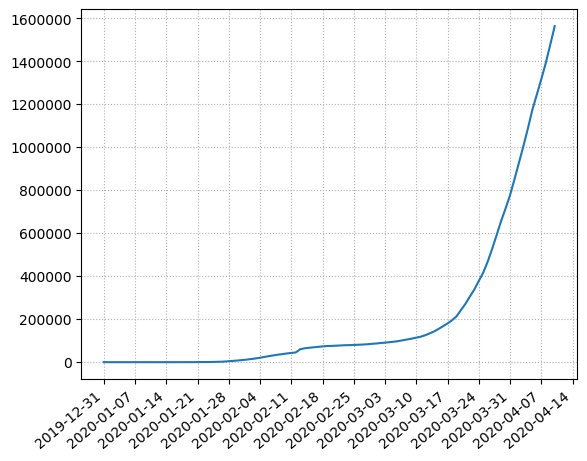

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 50
%matplotlib agg

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for datum in izdvoji_drzavu('China')['Date'][::-1]:
        for broj in data[data['Date']==datum][argument]:
            suma += broj
        lista.append(suma)
    return lista

def pokazi_stanje_u_svijetu(argument):
    base =dtt.datetime(2019, 12, 31)
    dates2 = np.array([base + dtt.timedelta(days = i*7) for i in range (0, 16)])
    fig, ax = plt.subplots()
    ax.plot(np.array(izdvoji_drzavu('China')['Date'])[::-1], ukupno_dnevno_stanje(argument))
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    plt.grid(linestyle = ':')
    return fig

pokazi_stanje_u_svijetu('Cases')

Safa pogledajmo i kretanje broja preminulih:

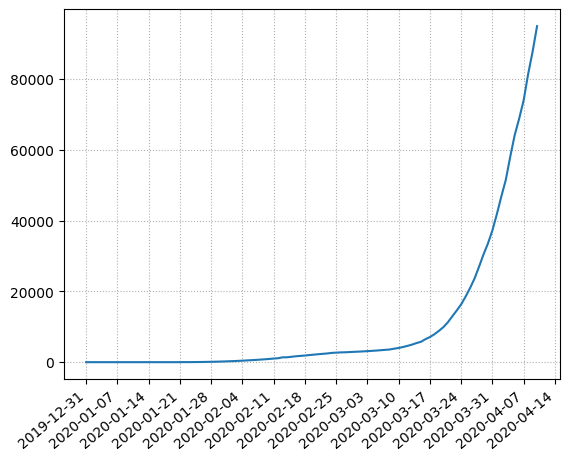

In [8]:
pokazi_stanje_u_svijetu('Deaths')

<b>NAPOMENE I IDEJE</b>:<br><br>
<lu>
    <li>Paziti da ovo doista bude priča, a ne samo crtanje lijepih grafova u raznim bojama!</li>
    <li>Ubaciti usporedbe, ali te usporedbe neka se temelje na <b>udjelu</b> zaraženih!</li>
    <li>Te usporedbe neka budu između nekih <i>vodećih</i> država po broju zaraženih.</li>
    <li>Prikaz dnevnih brojki prebaciti u histogram, ne graf.</li>
    <li>Poseban fokus staviti na Hrvatsku i njezine brojke. Prikupiti dodatne brojke iz svoje tablice (tj. stranice koronavirus.hr) i prikazati ih.</li>
    <li>Usporediti Hrvatsku sa susjedima.</li>
    <li>Primjeniti linearnu regresiju (možda bolje za svijet, ali i za Hrvatsku bi bilo zgodno).</li>
</lu>